# Sports Network and Twitter Analytics
#### Mitch Walden and Jonathan Reiff

## 1 Business and Data Understanding

### Business Questions
* What sports are these media platforms tweeting about the most?
* What are people tweeting about to these networks (are they problems, facts, or opinions)?
* What factors make a sports tweet more popular?
* Do hashtags, media, or mentions improve tweet popularity?

How can we add value to to these tweets for Sports Networks? We will examine a collection of tweets from Major Sports Networks to identify factors for creating popular content that will engage a larger share of the market. 





## 2 Importing Packages

In [41]:
# import popular packages
import csv
import pandas as pd
import re
import json
from collections import Counter
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import emoji
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

import gensim
from gensim.corpora import Dictionary
from gensim.models import ldamodel
from gensim import corpora, models, similarities

from gensim.models.coherencemodel import CoherenceModel
from gensim.models.wrappers import LdaVowpalWabbit, LdaMallet

import pyLDAvis.gensim

import numpy

stopwords =  set(stopwords.words('english'))
pd.set_option('display.max_colwidth', -1)

C:\ProgramData\Anaconda3\lib\site-packages\past\types\oldstr.py:33: DeprecationWarning: invalid escape sequence \d
  """


## 3 Data Identification and Collection



We have gathered several sets of data. The first group are three different CSV files containing the approximately 3200 tweets each from the three major networks, ESPN, FoxSports, and CBS Sports. These were collecting using Twitter API to scrape tweets from users. A separate python3 file is posted with the exact script for data collection. These tweets are mostly recent, which causes some bias in the analysis we do. The oldest tweets in these datasets come from December 2018, which means many of the tweets fall during basketball season and the end of football season, while baseball season is largely missed. This will affect the topic modeling and other content anaylsis. 

The other data set is a collection of tweets that contain the text 'ESPN', 'foxsports' or 'cbssports'. This was gathered for several hours using a twitter streaming script that collects tweets as they happen. This set was collected to see what people are saying about these sports networks by looking at the sentiment of these tweets and common words used in each one. This will help these Networks understand how they are viewed by the public. 


In [42]:
# Import the CSVs to pandas

dfe = pd.read_csv("espntweets.csv", header=None)
dff = pd.read_csv("foxtweets.csv", header=None)
dfc = pd.read_csv("cbstweets.csv", header=None)

In [43]:
#Renaming the columns

dfe.columns = ['text', 'favorites', 'retweets']
dfc.columns = ['text', 'favorites', 'retweets']
dff.columns = ['text', 'favorites', 'retweets']

In [44]:
#Retweets have 0 favorites, so we remove any retweets from the data

dfe1 = dfe[dfe.favorites != 0]
dfc1 = dfc[dfc.favorites != 0]
dff1 = dff[dff.favorites != 0]

In [45]:
# Create popularity score column

dfe1['popularity'] = dfe1['favorites'] + dfe1['retweets']
dfc1['popularity'] = dfc1['favorites'] + dfc1['retweets']
dff1['popularity'] = dff1['favorites'] + dff1['retweets']

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] 

In [46]:
# Sort by top favorites first

dfe1 = dfe1.sort_values(by=['popularity'], ascending=False)
dfc1 = dfc1.sort_values(by=['popularity'], ascending=False)
dff1 = dff1.sort_values(by=['popularity'], ascending=False)

In [47]:
# Top ESPN Favorited Tweets

dfe1.head()

,text,favorites,retweets,popularity
2009,This athlete with cerebral palsy just deadlifted 200 pounds ... and he only weighs 99 💪 https://t.co/KBRkXRNUG7,276841,54134,330975
783,16 months ago a tackle left Ryan Shazier unable to walk.\n\nHe's now doing box jumps 🙏 (via @RyanShazier) https://t.co/S6nKxs2zlu,146919,24472,171391
1673,"""WHO DO YOU THINK YOU ARE? I AM!""\n\n7 years ago today, a legendary catchphrase was born. https://t.co/acbJPWZcOK",133871,34842,168713
1410,Not all heroes wear capes 🤣 https://t.co/2vIGLykC4o,137064,28885,165949
2133,Stephen Gostkowski misses the 46-yard FG! https://t.co/jEUct0ObCr,124150,33366,157516


In [48]:
# Top CBSSports Favorited Tweets

dfc1.head()

,text,favorites,retweets,popularity
2706,What an incredible moment. https://t.co/bvX80tkrzG,31557,9188,40745
221,Simply incredible. https://t.co/cWIpdMpfzy,23994,5484,29478
2702,Jalen Hurts could’ve left Alabama after being benched. \nHe could’ve sulked. \nHe didn’t. \nHe stayed ready. \nHe delivered when his team needed him. \nHe’s achieved the ultimate redemption. https://t.co/7Emx4AwfMa,15854,4509,20363
219,"""THE RETURN TO GLORY!"" \n\nTiger Woods wins the Masters for the 5th time. https://t.co/u3cNdQm6MG",13347,4729,18076
2607,"It takes a different kind of kid to commit to protecting our country.\n\nFor the 119th time, The Army-Navy Game celebrates that choice. https://t.co/PyfPCEZJmb",11589,4397,15986


In [49]:
# Top FoxSports Favorited Tweets

dff1.head()

,text,favorites,retweets,popularity
3051,Big Papi reacting to that JBJ @RedSox grand slam is everything. https://t.co/lZNUwLmpG8,29301,10468,39769
3240,KHABIB SMASH! https://t.co/bQsnDDUxi1,10489,6403,16892
2751,THE BOSTON RED SOX ARE WORLD CHAMPIONS!!!\n\nChris Sale strikes out Manny Machado to close out the World Series! https://t.co/u62k4SVQPv,6333,2827,9160
1230,Maybe the most memorable play in Super Bowl history.\n\nThe moment the Giants turned 18-0 into 18-1. (via @nflthrowback) https://t.co/NJj6ddUlgj,6708,2159,8867
1585,THE COWBOYS ARE MOVING ON! https://t.co/Wm8laHgo5g,5462,2162,7624


## 4 Data Cleaning and Text Preprocessing

In [50]:
# Save emoji to new column

dfe1['emojis'] = dfe1["text"].apply(lambda x: ''.join(c for c in x if c in emoji.UNICODE_EMOJI))
dfc1['emojis'] = dfc1["text"].apply(lambda x: ''.join(c for c in x if c in emoji.UNICODE_EMOJI))
dff1['emojis'] = dff1["text"].apply(lambda x: ''.join(c for c in x if c in emoji.UNICODE_EMOJI))

In [51]:
# Create seperate column for cleaned data

dfe1['cleaned'] = dfe1['text'].apply(str)
dff1['cleaned'] = dff1['text'].apply(str)
dfc1['cleaned'] = dfc1['text'].apply(str)

In [52]:
# Remove URLS, alphanumberic, numberic, and words less than 3

dfe1['cleaned'] = dfe1.cleaned.str.lower()
dfe1['cleaned'] = dfe1.cleaned.str.replace('http\S+|www.\S+', '')
dfe1['cleaned'] = dfe1.cleaned.str.replace('[^a-zA-Z]', ' ')
dfe1['cleaned'] = dfe1.cleaned.str.findall('\w{3,}').str.join(' ')

dfc1['cleaned'] = dfc1.cleaned.str.lower()
dfc1['cleaned'] = dfc1.cleaned.str.replace('http\S+|www.\S+', '')
dfc1['cleaned'] = dfc1.cleaned.str.replace('[^a-zA-Z]', ' ')
dfc1['cleaned'] = dfc1.cleaned.str.findall('\w{3,}').str.join(' ')

dff1['cleaned'] = dff1.cleaned.str.lower()
dff1['cleaned'] = dff1.cleaned.str.replace('http\S+|www.\S+', '')
dff1['cleaned'] = dff1.cleaned.str.replace('[^a-zA-Z]', ' ')
dff1['cleaned'] = dff1.cleaned.str.findall('\w{3,}').str.join(' ')

<>:4: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \w
<>:14: DeprecationWarning: invalid escape sequence \S
<>:16: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \w
<>:14: DeprecationWarning: invalid escape sequence \S
<>:16: DeprecationWarning: invalid escape sequence \w
<>:4: DeprecationWarning: invalid escape sequence \S
<>:6: DeprecationWarning: invalid escape sequence \w
<>:9: DeprecationWarning: invalid escape sequence \S
<>:11: DeprecationWarning: invalid escape sequence \w
<>:14: DeprecationWarning: invalid escape sequence \S
<>:16: DeprecationWarning: invalid escape sequence \w
<ipython-input-52-272a69c14c8f>:4: De

In [53]:
# Remove stopwords

dfe1['cleaned'] = dfe1['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
dff1['cleaned'] = dff1['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))
dfc1['cleaned'] = dfc1['cleaned'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [54]:
# Combine dataframes to analyze word frequency

frames = [dfe1, dff1, dfc1]
results = pd.concat(frames)

In [55]:
len(results)

6494

## 5 Descriptive Analytics

### 5.1 Tweets from Networks

In [56]:
# create length column to show number of words in each tweet
results['length'] = results['text'].apply(lambda x: len(x.split()))

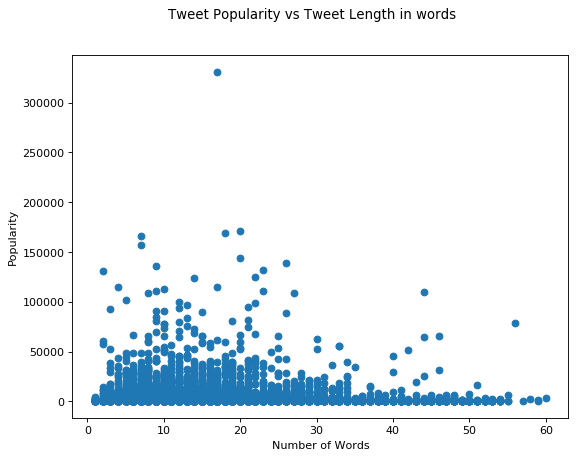

In [57]:
# create a plot for tweet length vs popularity

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results.length, results.popularity)
fig.suptitle('Tweet Popularity vs Tweet Length in words')
plt.xlabel('Number of Words')
plt.ylabel('Popularity')
plt.show()
fig.savefig('length_vs_popularity.jpg')

#### 5.1.1 Effect of number of words in tweets
The left-skew in this chart shows that typically tweets with less words have a higher popularity (popularity = retweets + likes). This could be flawed due to an overwhelming majority of tweets having fewer words, but the presence of the skew leads one to believe that shorter tweets tend to get a higher response from users.

In [58]:
# Most popular words from all the networks combined

fdist = list(Counter(" ".join(results['cleaned']).split(" ")).items())

freq_word = []

for k,v in fdist:
    freq_word.append([k,v])
    
wordlist = pd.DataFrame(freq_word)
wordlist.sort_values(1, ascending=False).head(30)

,0,1
50,game,661
16,via,456
485,lebron,413
73,one,371
280,time,325
250,first,318
303,win,301
40,team,275
230,going,268
216,back,267


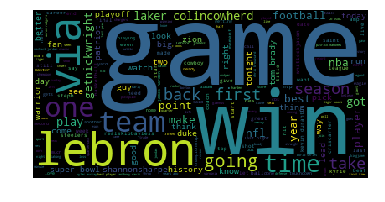

In [59]:
# generate WordCloud of most Popular Words all together

wordcloud = WordCloud().generate(' '.join(results['cleaned']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

#### 5.1.2 Common Words effect on success
Above are the most common words used in tweets from all of the sports networks. This illustration is to show what words are common and usually get a good response from users, so words like game, Lebron, win and team are all very frequently used across all sports networks. However, a company could also look at this list and see these words as over-used, and find a way to make more creative, engaging tweets utilizing words and stories that break from the norm. Either way, it seems like users want to hear about Lebron James, so whether your network is going for differentiation or trying to fit into the market, tweeting about Lebron seems to be an easy way to engage this market. 

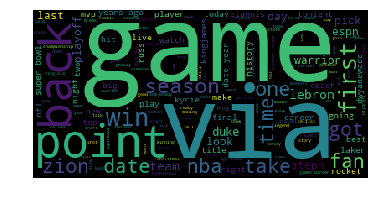

In [60]:
# generate WordCloud of most Popular Words from ESPN

wordcloud = WordCloud().generate(' '.join(dfe1['cleaned']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

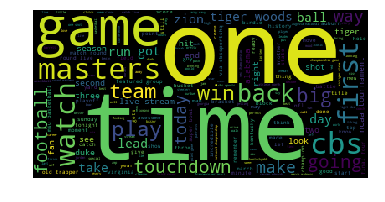

In [61]:
# generate WordCloud of most Popular Words from CBSSports

wordcloud = WordCloud().generate(' '.join(dfc1['cleaned']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

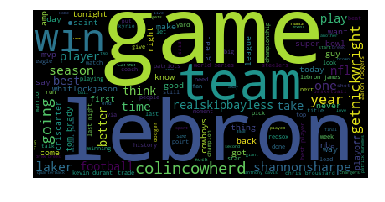

In [62]:
# generate WordCloud of most Popular Words from FoxSports

wordcloud = WordCloud().generate(' '.join(dff1['cleaned']))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [63]:
# Create hashtags column- find most popular hashtags
results['hashtags'] = results.text.str.findall("(?<=#)\w+")

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-63-850fa0221f89>:2: DeprecationWarning: invalid escape sequence \w
  results['hashtags'] = results.text.str.findall("(?<=#)\w+")


In [64]:
# Show number of hashtags used
hashtags = []
for i in results['hashtags']:
    if i != []:
        hashtags.append(i)
len(hashtags)

546

In [65]:
# create boolean column called has#

results['has#'] = results['hashtags'].apply(lambda x: 0 if x == [] else 1)

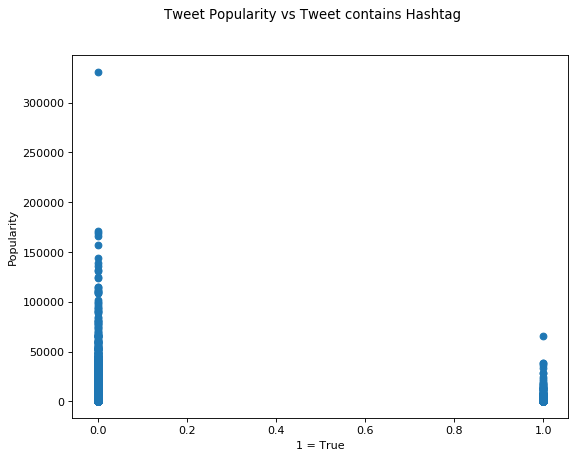

In [66]:
# create a plot for has hashtag and popularity

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results['has#'], results.popularity)
fig.suptitle('Tweet Popularity vs Tweet contains Hashtag')
plt.xlabel('1 = True')
plt.ylabel('Popularity')
plt.show()
fig.savefig('hash_vs_popularity.jpg')

In [69]:
# Number of tweets containing hashtag or not
results.groupby(results['has#'].apply(lambda x: 'does not have hashtag' if x == 0 else 'has hashtag'))['has#'].count()

has#
does not have hashtag    5948
has hashtag              546 
Name: has#, dtype: int64

#### 5.1.3 Effect of Hashtags on popularity
Hashtags are not used often in tweets from these sports networks. We see that there are nearly 6000 tweets without them and only 546 tweets that include hashtags. This is a huge skew to our data, but it does appear that most tweets that get a higher than average number of likes do not utilize hashtags. This could be biased because of the small sample size of tweets that do include hashtags, but it seems safe to say a tweet does not need a hashtag to be successful. 

In [70]:
# Create mentions column- find most popular mentions
results['mentions'] = results.text.str.findall("(?<=@)\w+")

<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<>:2: DeprecationWarning: invalid escape sequence \w
<ipython-input-70-65b16a4b7f26>:2: DeprecationWarning: invalid escape sequence \w
  results['mentions'] = results.text.str.findall("(?<=@)\w+")


In [71]:
# Show number of mentions used
mentions = []
for i in results['mentions']:
    if i != []:
        mentions.append(i)
len(mentions)

3015

In [72]:
# create boolean column called hasmen

results['hasmen'] = results['mentions'].apply(lambda x: 0 if x == [] else 1)

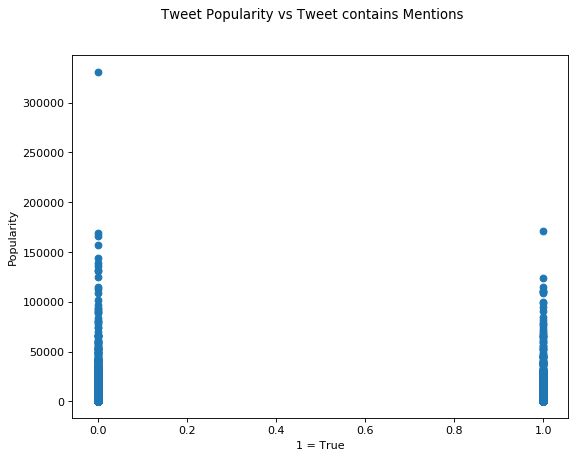

In [73]:
# create a plot for has mention and popularity

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(results['hasmen'], results.popularity)
fig.suptitle('Tweet Popularity vs Tweet contains Mentions')
plt.xlabel('1 = True')
plt.ylabel('Popularity')
plt.show()
fig.savefig('men_vs_popularity.jpg')

In [74]:
# Number of tweets containing mention or not
results.groupby(results['hasmen'].apply(lambda x: 'does not have mention' if x == 0 else 'has mention'))['hasmen'].count()

hasmen
does not have mention    3479
has mention              3015
Name: hasmen, dtype: int64

#### 5.1.4 Effect of Mentions on Popularity
Mentions do not have a large effect on popularity of tweets from sports networks. We see that a little less than half of all tweets contain a mention, and the popularity scores are relatively similar for the tweets with mentions and the tweets without,

### 5.2 Tweets from users about Networks

In [6]:
# create an empty list to store our tweets in
data = []

# append each line of the data to our tweets list using the json module
for line in open('SNtwitterdata.json'):
    try:
        data.append(json.loads(line))
    except:
        pass

# lets see how many we got
print(len(data))

14146


In [7]:
# removing any error messages from Twitter API

tweets1 = []
for T in data:
    if 'text' in T:
        tweets1.append(T)

In [8]:
#Saving only english tweets
tweets = []
for i in tweets1:
    if i['user']['lang'] == "en":
        tweets.append(i)
len(tweets)

13012

In [9]:
# save screen_names
screen_names = [T['user']['screen_name'] for T in tweets]
len(screen_names)

13012

In [10]:
# More codes for extracting information from tweets

ids = [T['id_str'] for T in tweets]
times = [T['created_at'] for T in tweets]
texts = [T['text'] for T in tweets]
screen_names = [T['user']['screen_name'] for T in tweets]
followers_count = [T['user']['followers_count'] for T in tweets]
friends_count = [T['user']['friends_count'] for T in tweets]
names = [T['user']['name'] for T in tweets]
lats = [(T['geo']['coordinates'][0] if T['geo'] else None) for T in tweets]
lons = [(T['geo']['coordinates'][1] if T['geo'] else None) for T in tweets]
place_names = [(T['place']['full_name'] if T['place'] else None) for T in tweets]
place_types = [(T['place']['place_type'] if T['place'] else None) for T in tweets]

# open an output csv file to write to
out = open('tweetdata.csv', 'w', encoding='UTF-8', newline='')

# write the header of our CSV as its first line
out.write('id,created at,text,screen name,followers_count,friends_count,name,lat,lon,place name,place type\n')

# merge each individual list into a single list using the zip function
rows = list(zip(ids, times, texts, screen_names, followers_count, friends_count, names, lats, lons, place_names, place_types))

# use the writer module on our csv file
csv = csv.writer(out)

# use one value from each of our rows list and write it to the csv as a new row
for row in rows:
    values = [value for value in row]
    #values = [(value.encode('utf8') if hasattr(value, 'encode') else value) for value in row]
    csv.writerow(values)

# close our csv file when done
out.close()

#http://mike.teczno.com/notes/streaming-data-from-twitter.html

In [75]:
#move tweets to dataframe
df = pd.read_csv("tweetdata.csv")


In [76]:
from collections import Counter

c = Counter(screen_names)

# how many unique users in the data?
len(c)

12292

In [77]:
#how many tweets per user?
float(len(tweets)/len(c))

1.0585746827204685

In [78]:
# remove retweets so you can extract all original tweets and save them

originaltweets = []

# for loop

for tweet in texts:
    if 'rt @' not in tweet.lower():
        originaltweets.append(tweet)

        
len(originaltweets)

2964

In [79]:
# % original tweets

float(len(originaltweets)/len(tweets)*100)

22.778973255456503

In [80]:
# get retweets only

#remove original tweets

retweets_only = []

for tweet in texts:
    if 'rt @' in tweet.lower():
        retweets_only.append(tweet)

len(retweets_only)

10048

In [81]:
# %  retweets

float(len(retweets_only)/len(tweets)*100)

77.2210267445435

In [82]:
# save urls

urls = []

for T in tweets:
    for i in T['entities']['urls']:
        urls.append(i['url'])

#top 10 urls 

c = Counter(urls)
c.most_common(10)

[('https://t.co/wZrV7xpzYX', 52),
 ('https://t.co/wHgn90Wg9e', 27),
 ('https://t.co/wHgn90EFhG', 18),
 ('https://t.co/AGynWgqtj6', 15),
 ('https://t.co/oi9Y5Ec1AC', 9),
 ('https://t.co/8fpR0QMdIY', 9),
 ('https://t.co/4Qlk8KhvUH', 6),
 ('https://t.co/kPIx8HlDXM', 6),
 ('https://t.co/ECMFcI9tcX', 6),
 ('https://t.co/Wi2RYabN2g', 6)]

In [83]:
# URLs per tweet

float(len(urls)/len(tweets))

0.10943744236089763

In [84]:
# Clean the tweets more for text analytics
texts_clean_completely2 = []

for i in texts:
    result = ' '.join(re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", i).split())
    texts_clean_completely2.append(result)

texts_clean_completely2[:5]

['RT The Boston Celtics will be the New England Patriots and completely dominate a conference for the next 10 years',
 'RT when its 4 AM and your friends are making more plans',
 '',
 'RT when its 4 AM and your friends are making more plans',
 'RT when its 4 AM and your friends are making more plans']

In [85]:
# tokenize the words for analysis

import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

#convert lists to strings
originaltweets = str(texts_clean_completely2)

#lowercase
tokens = originaltweets.lower()

#tokenize
tokens = tokens.split()

#Remove stopwords
tokens = (word for word in tokens if word not in stopwords.words('english'))

# Filter non-alphanumeric chars from tokens
tokens = (ch.lower() for ch in tokens if ch.isalpha())

#Create your bigrams
#bgs = nltk.bigrams(tokens)

#compute frequency distribution for all the bigrams in the text
fdist = nltk.FreqDist(tokens)

#k refers to keys (or tokens); v refers to values (or counts)
for k,v in list(fdist.items())[:10]:
    print(k,v)

boston 16
celtics 144
new 151
england 1
patriots 2
completely 2
dominate 1
conference 19
next 45
friends 6546


In [25]:
# What are the most used words in these tweeets?
fdist.most_common(10)

[('making', 6548),
 ('friends', 6546),
 ('series', 740),
 ('even', 725),
 ('home', 718),
 ('tied', 715),
 ('court', 684),
 ('uprockets', 669),
 ('defend', 669),
 ('espn', 563)]

#### 5.2 Summary of Tweets about Networks
Tweets about these networks from users tend to have to do with the sports that are going on during that time. These tweets were gathered during the NBA playoffs, which are shown on ESPN. So many of these tweets contained words like even, series, home, tied, court, defend and espn. Many of the tweets collected about these networks are retweets also, about 77% of the total data.

## 6 Content Analytics
### 6.1 Sentiment Analysis
#### 6.1.1 Tweets from networks

In [86]:
# Run a vader sentiment analysis on the tweets

vs = SentimentIntensityAnalyzer()

dfe1['sent_score'] = dfe1['text'].apply(lambda x: vs.polarity_scores(x)['compound'])
dff1['sent_score'] = dff1['text'].apply(lambda x: vs.polarity_scores(x)['compound'])
dfc1['sent_score'] = dfc1['text'].apply(lambda x: vs.polarity_scores(x)['compound'])

Text(0, 0.5, 'Popularity')

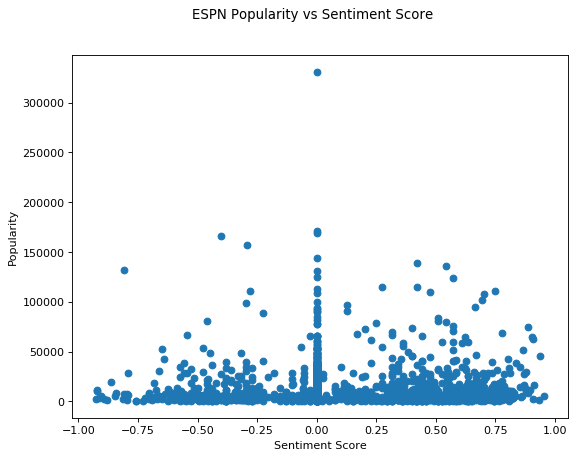

In [87]:
# create a plot for ESPN popularity vs sent score

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(dfe1.sent_score, dfe1.popularity)
fig.suptitle('ESPN Popularity vs Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Popularity')
#fig.savefig('espnpopsent.jpg')

Above we see ESPN's tweet popularity based on sentiment score. There seems to be a skew right, with more tweets havaing a positive sentiment. Due to the difference in number of tweets, it can appear that the more popular tweets have positive sentiment scores, but this may be due to the smaller sample of negative sentiment tweets. Either way, it seems more intuitive to have positive sentiment tweets in order to have a positive brand image. There are a great deal of tweets that fall on the neutral value for sentiment, and this group includes the most popular tweet in the set. This shows that sentiment is not a strong factor in success for a tweet from a sports network.

Text(0, 0.5, 'Popularity')

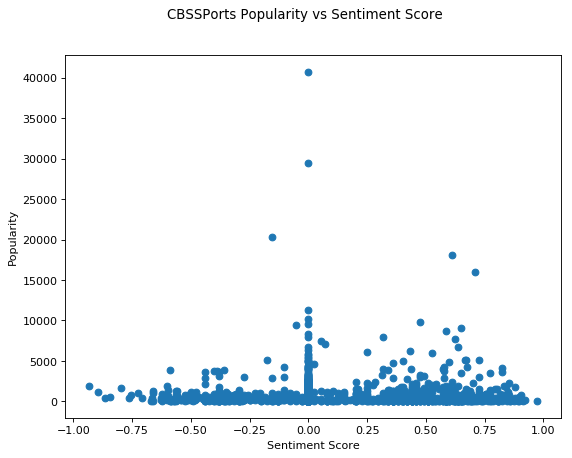

In [88]:
# create a plot for CBS popularity vs sent score

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(dfc1.sent_score, dfc1.popularity)
fig.suptitle('CBSSPorts Popularity vs Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Popularity')
#fig.savefig('cbspopsent.jpg')

The above plot shows Popularity vs Sentiment Score for CBS Sports tweets. This set follows a similar trend as ESPN, just with less overall popularity than ESPN. CBS tweets have more of a clear correlation with popularity and sentiment score with a right skew, showing that their higher sentiment tweets have most of the more popular tweets. Again, there is a large neutral group that inlcudes the most popular data point in the plot, so any tweet that is at least neutral is more likely score a higher popularity score. 

Text(0, 0.5, 'Popularity')

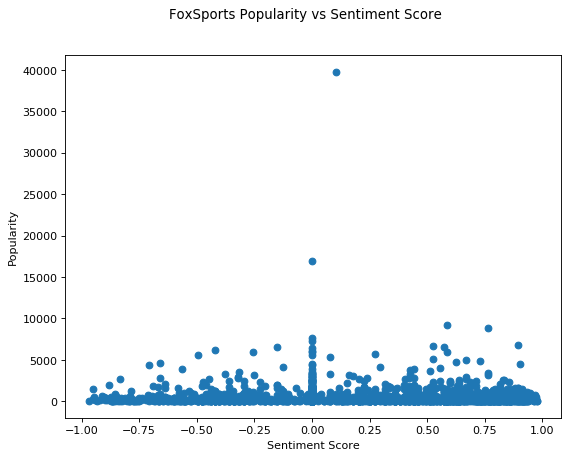

In [89]:
# create a plot for Fox popularity vs sent score

fig = plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(dff1.sent_score, dff1.popularity)
fig.suptitle('FoxSports Popularity vs Sentiment Score')
plt.xlabel('Sentiment Score')
plt.ylabel('Popularity')
#fig.savefig('foxpopsent.jpg')

FoxSports tweets have a vaguely similar plot to the other two networks, reinforcing the idea that sentiment score is not a significant predictor of popularity. There is a slight right skew, with the highest score coming from a tweet with a slightly positive sentiment score. FoxSports has the least popular tweets of the three networks we collected data from. There is a clear drop off when tweets get extremely negative, the popularity seems to drop significantly as well.

#### 6.1.2 Tweets from users about Networks

In [33]:
# create a column in the dataframe that displays sentiment of the tweets
df['score'] = df['text'].apply(lambda x: vs.polarity_scores(x)['compound'])


In [34]:
# average compound sentiment score
x = 0 
for i in df['score']:
    x = x + i

x/len(df)

0.28801295727024356

In [35]:
# Number of tweets by sentiment score
df.groupby(df['score'].apply(lambda x: 'negative' if x < -0.1 else 'positive' if x > 0.1 else 'neutral'))['score'].count()

score
negative    1091
neutral     3254
positive    8667
Name: score, dtype: int64

Most of the tweets from users about these networks have a positive sentiment, which is a good sign for the networks. Whatever people are saying, whether it has to do with the networks or the games that are going on, it is a positive sign that tweets containing the network names generally have a positive senitment. 

### 6.2 Topic Modeling

In [91]:
# convert dataframe into list from results

texts = results['text'].values

In [92]:
len(texts)

6494

In [93]:
texts[:5]

array(['This athlete with cerebral palsy just deadlifted 200 pounds ... and he only weighs 99 💪 https://t.co/KBRkXRNUG7',
       "16 months ago a tackle left Ryan Shazier unable to walk.\n\nHe's now doing box jumps 🙏 (via @RyanShazier) https://t.co/S6nKxs2zlu",
       '"WHO DO YOU THINK YOU ARE? I AM!"\n\n7 years ago today, a legendary catchphrase was born. https://t.co/acbJPWZcOK',
       'Not all heroes wear capes 🤣 https://t.co/2vIGLykC4o',
       'Stephen Gostkowski misses the 46-yard FG! https://t.co/jEUct0ObCr'],
      dtype=object)

In [ ]:
texts = [re.sub(r"http\S+", "", x) for x in texts]
documents = [re.sub("[^a-zA-Z0-9]+", " ", str(document)) for document in texts]

texts = [ document.lower().split() for document in documents]

lmtzr = WordNetLemmatizer()
texts = [[lmtzr.lemmatize(word) for word in tokens] for tokens in texts]

texts = [[word for word in tokens if word not in stopwords] for tokens in texts]

texts = [[word for word in tokens if len(word) >= 3] for tokens in texts]

In [95]:
len(texts)

6494

In [243]:
dictionary = Dictionary(texts)
dictionary.save('tweets.dict')

len(dictionary)

8236

In [244]:
dictionary.filter_extremes(no_below=2, no_above=0.5)
len(dictionary)

4545

In [245]:
corpus = [dictionary.doc2bow(text) for text in texts]
corpora.MmCorpus.serialize('tweets.mm', corpus)
len(corpus)

6494

In [246]:
print(('Number of unique tokens: %d' % len(dictionary)))
print(('Number of documents: %d' % len(corpus)))

Number of unique tokens: 4545
Number of documents: 6494


In [261]:
numpy.random.seed(1)

model = ldamodel.LdaModel(corpus, id2word=dictionary, num_topics = 15, passes=30)

In [262]:
model.save('lda.model')

In [263]:
for i in range(0,15):
    topics = model.show_topic(i,5)
    print(', '.join([str(word[0]) for word in topics]))

run, touchdown, game, point, yard
cbs, watch, big, live, also
master, tiger, shot, lead, wood
get, ready, one, kyrie, criscarter80
back, win, national, half, first
lebron, james, shannonsharpe, featured, harden
bowl, look, super, time, bracket
world, game, football, series, amp
season, last, night, game, start
colincowherd, getnickwright, basketball, lebron, best
old, team, want, trapper, brown
round, live, watch, group, athlete
nba, top, week, mvp, jordan
come, zion, one, point, got
today, new, year, fox, love


In [ ]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(model,corpus,dictionary,sort_topics=False)

#### 6.2.1 Topic Modeling Summary
By using LDA Modeling we were able to find 15 topics that were common among the tweets from sports networks. These show the most popular topics that these networks tweet about, like football, the Masters', Lebron James and the NBA, the Super Bowl, Zion Williamson and NCAA basketball, and the New Year. These networks must do their best to tweet about trendy topics and play to the interests of their market, so these topics help us understand which topics these networks value. A company can also look at this list and use it to help them form a differentiation strategy, and they could avoid these topics and find newer, untapped topics to cover and potentially find a new market of interested readers.

## 7 Network Analytics
### 7.1 Data Preparation
Here we analyze the network of mentions in the tweets gathered from users that contain the keyword 'espn' in order to see who is tweeting about espn and who else they are connecting espn too

In [117]:
tweets = df.values
len(tweets)

13012

In [118]:
#use data from users about networks to create network data

import csv

mention = []
for tweet in tweets:
    mention.append([tweet[2], tweet[3]])
    
openfile = open("data/mentionnetwork.csv", "w", newline='')
w = csv.writer(openfile)

for tweet in mention:
    a = re.findall(r"(?<=@)\w+", tweet[0])
    for i in a:
        w.writerow([tweet[1], i])
        
openfile.close()

### 7.2 Data Visualization
Visualization done in Gephi

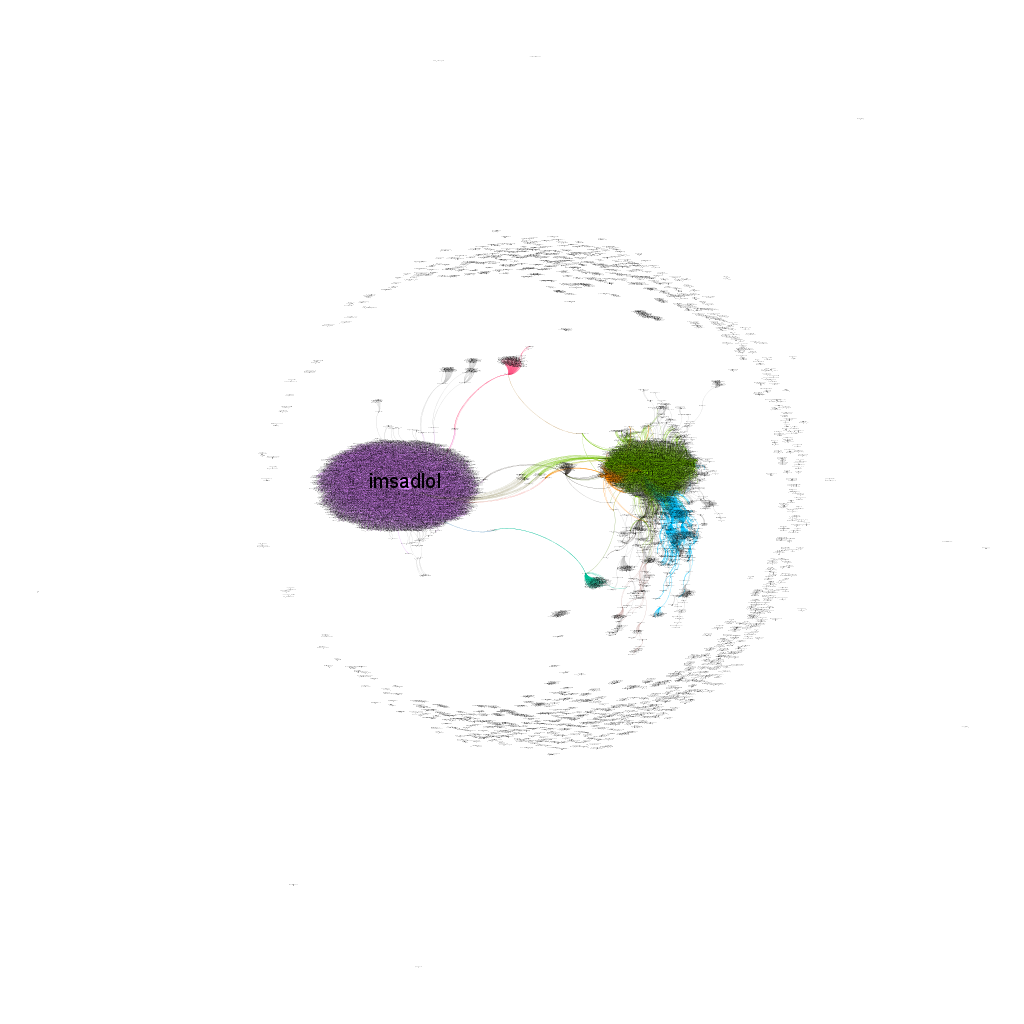

In [122]:
# paste network visualization
from IPython.display import Image
Image("Network_Image1.png")

## 8 Final Analysis and Storytelling

We sought out to find key success factors in Sports Network's tweets, seeing if we could find certain attributes of the tweeets that lead to more popularity or that appeal to a greater number of people. We asked several questions in order to accomplish this, like what sports are talked about most? What are users tweeting about most when tweeting about ESPN? How do hashtags and mentions affect the popularity of a tweet. We believe that it is important for these networks to use their social media presence to engage with a larger market. 

Below are our conclusions from the investigation of our business questions:

    -- We found that the number of words in a tweet seems to be a predictor of popularity (popularity is measured by adding retweets and likes for a given tweet). The when a tweet exceed about 25 or 30 words it becomes less likely to have a higher popularity score. 

    -- Next, we saw that the top 20 words used in tweets from the media platforms contained Lebron, NFL, NBA, football, Lakers and bowl. These words give us insight as to the topics that the media platforms tweet most about. This is useful for other sports media pages, because they can know what content the big platforms are focusing on and then can match them in order to compete for the same market, or they can differentiate from the common topics found here in order to gain interest from other untapped interested users.

    -- We also looked at the use of hashtags in tweets from these networks to see if they added any value to the popularity of the tweets. We found that most tweets did not contain hashtags, and those that did have them seemed to trend toward having less popularity than those without hashtags. 

    -- When looking at the effect of mentions of the popularity of tweets there did not seem to be much of a relationship. Mentions appeared in about half of the tweets and the popularity remained largely the same. 

    -- Next, we examined tweets from users on twitter that contained the word 'ESPN'. First we looked at the words used in these tweets. This revealed what was expected, many of the tweets were focused on the sports games playing on ESPN that night. This is useful for businesses to know so that they can potentially interact with users as the tweet about these games and events.

    -- Using sentiment analysis we looked at the tweets from the major sports networks to see how sentiment effects popularity. This analysis revealed that more tweets with neutral and positive sentiments are likely to have higher popularity scores. Something that stood out was that each of the highest popularity score tweets had a neutral sentiment score.

    -- Then we looked at sentiment of the tweets from users about ESPN, and this showed that most tweets about ESPN had a positive sentiment, which is helpful for a business to know. 

    -- Finally we used LDA modeling to determine topics within the tweets from sports networks. This revealed the topics that are frequently tweeted about by successful sports networks and is beneficial to know as a growing sports network. With this knowledge a network can know which topics need to be addressed in their tweets and also which topics are being over-hyped by certain media outlets. We found some of the topics to be about the Super Bowl, The Masters', Lebron and the NBA, and Football in general.  